In [53]:
# Calcula la precipitacion mensual media para el periodo
# 1979 - 2020 en la Cuenca del Valle de México.

import pandas as pd
import numpy as np

import xarray as xr

import matplotlib.pyplot as plt

In [54]:
path_r = "../results/onset/"
path_cpc = path_r  + "CPC_Pre/cuenca_valle_mexico/"
fname_cpc = "cuenca_valle_mexico_precip.nc"
fname_grid = "grid_points.csv"

# Se leen los límites de la cuenca.
df_grid = pd.read_csv(path_r + fname_grid)
lon_i = 360 + df_grid.lon.min()
lon_f = 360 + df_grid.lon.max() + 0.5
lat_i = df_grid.lat.min()
lat_f = df_grid.lat.max() + 0.5

# Se carga la precipitación.
pre_xr = xr.load_dataset(path_cpc + fname_cpc)
# Se recorta la zona de estudio.
pre_xr = pre_xr.sel( dict( lon = np.arange(lon_i, lon_f, 0.5),
    lat = np.arange(lat_i, lat_f, 0.5) ) )
pre_xr

<xarray.Dataset>
Dimensions:  (time: 15341, lon: 2, lat: 3)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2020-12-31
  * lon      (lon) float32 260.8 261.2
  * lat      (lat) float32 19.25 19.75 20.25
Data variables:
    precip   (time, lat, lon) float32 0.0 0.0 0.0 0.3647 ... 0.0 0.0 0.0 0.0
Attributes:
    CDI:            Climate Data Interface version 1.9.6 (http://mpimet.mpg.d...
    history:        Wed Dec 01 15:53:28 2021: cdo mergetime cuenca_valle_mexi...
    Conventions:    CF-1.0
    version:        V1.0
    title:          CPC GLOBAL PRCP V1.0
    dataset_title:  CPC GLOBAL PRCP V1.0
    References:     https://www.psl.noaa.gov/data/gridded/data.cpc.globalprec...
    CDO:            Climate Data Operators version 1.9.6 (http://mpimet.mpg.d...

In [94]:
df_grid.sort_values("lat", ascending = False, inplace = True)
df_grid.reset_index(drop = True, inplace = True)

df_grid

,lon,lat,Per_intersect,Per_cuenca,Per_cuenca_cumsum
0,-99.25,20.25,0.996525,0.171197,0.448990
1,-98.75,20.25,0.524306,0.092007,0.829030
2,-99.25,19.75,0.980992,0.172127,0.277793
3,-98.75,19.75,1.000000,0.179325,0.737023
4,-99.25,19.25,0.589698,0.105666,0.105666
5,-98.75,19.25,0.593282,0.108708,0.557698


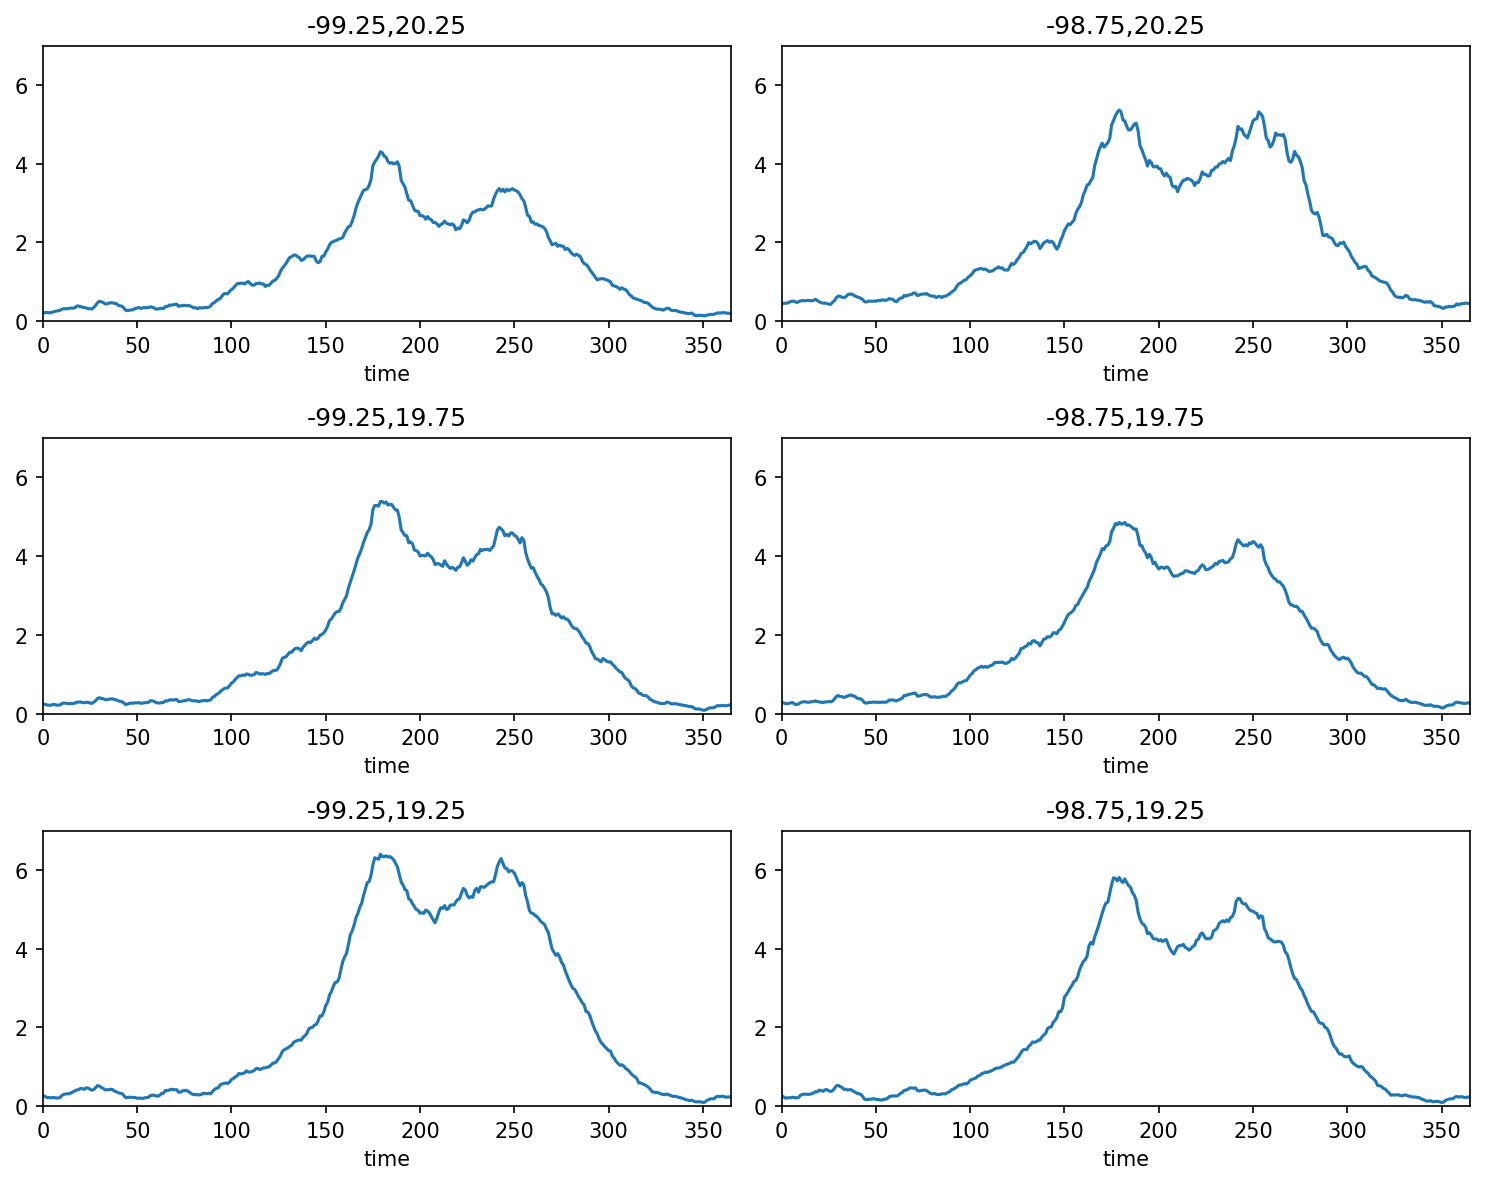

In [101]:
df = pd.DataFrame()

i = 0
for i in range( df_grid.shape[0] ):
    df[f"{df_grid.loc[i, 'lon']}," +
        f"{df_grid.loc[i, 'lat']}"] = (
        pre_xr.sel( {
            "lon": 360 + df_grid.loc[i, 'lon'],
            "lat": df_grid.loc[i, 'lat']
        } ).to_dataframe()["precip"]
        .rolling(15, center = True).mean() )

df = df.groupby(df.index.dayofyear).mean()

fig, axes = plt.subplots(nrows = 3, ncols = 2)
fig.set_size_inches(10, 8)
fig.set_dpi(150)

df

df.iloc[:, 0].plot(ax = axes[0, 0], title = df.iloc[:, 0].name)
df.iloc[:, 1].plot(ax = axes[0, 1], title = df.iloc[:, 1].name)
df.iloc[:, 2].plot(ax = axes[1, 0], title = df.iloc[:, 2].name)
df.iloc[:, 3].plot(ax = axes[1, 1], title = df.iloc[:, 3].name)
df.iloc[:, 4].plot(ax = axes[2, 0], title = df.iloc[:, 4].name)
df.iloc[:, 5].plot(ax = axes[2, 1], title = df.iloc[:, 5].name)

fig.tight_layout()

for ax in axes.flatten():
    ax.set_xlim(0, 365)
    ax.set_ylim(0, 7)